#**Estimation de l'âge de l'ormeau dans une ferme de fruits de mer**


*   Importation des données et des bibliothèques
*   Éxploration de données

    *   Analyse univariée, Analyse multivariée et detection des outliers (Dynamic outliers detector) : DAX-power BI
    *   Detection et traitement des outliers : Python
    *   Features engineering


*   Creation de Modéle

    *   1 er Modéle : Neural network
    *   2 eme Modéle : Gradient Boosting Regressor



    


##**Importation des données et des bibliothèques**



*   **Source de données** : Kaggel
*   **URL** : https://www.kaggle.com/datasets/devzohaib/estimating-the-age-of-abalone-at-a-seafood-farm


*   **Description** : Ce projet consiste à aider les agriculteurs à estimer l'âge de l'ormeau à partir de ses caractéristiques physiques





In [32]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("abalone.csv")

In [ ]:
data.rename(columns = {'length':'length(mm)','diameter':'diameter(mm)','height':'height(mm)','whole_wt':'whole(mm)', 'shucked_wt':'weight_whole(grams)','viscera_wt':'weight_shell(grams)','shell_wt':'weight_gut(grams)'}, inplace = True)

##**Éxploration de données**


###**Identification des variables**

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   length(mm)           4177 non-null   float64
 1   diameter(mm)         4177 non-null   float64
 2   height(mm)           4177 non-null   float64
 3   whole(mm)            4177 non-null   float64
 4   weight_whole(grams)  4177 non-null   float64
 5   weight_shell(grams)  4177 non-null   float64
 6   weight_gut(grams)    4177 non-null   float64
 7   rings                4177 non-null   int64  
 8   age                  4177 non-null   float64
 9   F                    4177 non-null   int64  
 10  I                    4177 non-null   int64  
 11  M                    4177 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 391.7 KB


###**Analyse univariée, Analyse multivariée et detection des outliers (Dynamic outliers detector)**
Dans cette partie, on a utilise Power BI-DAX

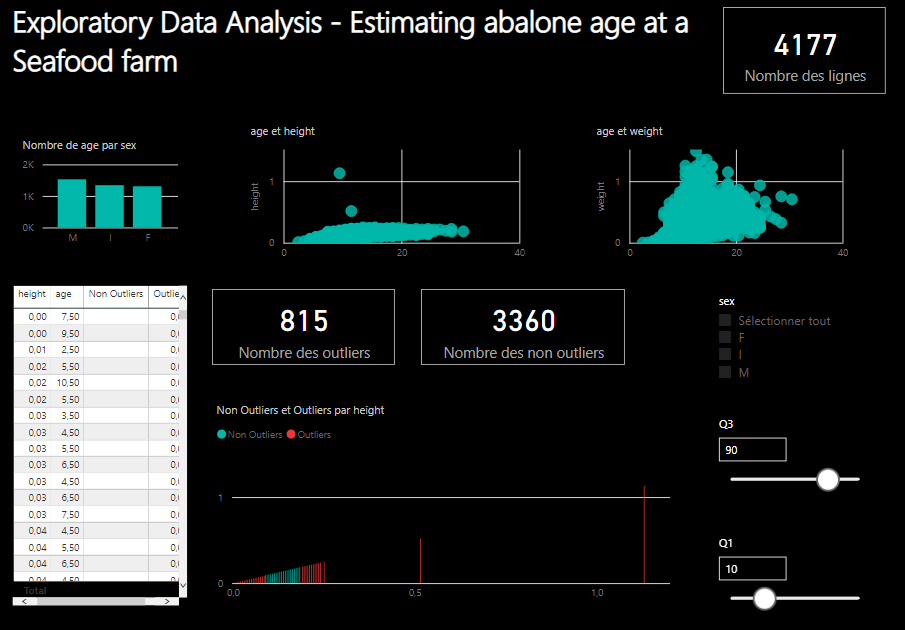

###**Detection et traitement des outliers**

In [ ]:
d = {1: ["length(mm)",data["length(mm)"].skew()],
2: ["diameter(mm)",data["diameter(mm)"].skew()],
3: ["height(mm)",data["height(mm)"].skew()],
10: ["whole(mm)",data["whole(mm)"].skew()],
5: ["weight_whole(grams)",data["weight_whole(grams)"].skew()],
6: ["weight_shell(grams)",data["weight_shell(grams)"].skew()],
7: ["weight_gut(grams)",data["weight_gut(grams)"].skew()],
8: ["rings",data["rings"].skew()],
9: ["age",data["age"].skew()]
}
print ("{:<20} {:<10}".format('columns','skew value'))
for k, v in d.items():
    c, s_v = v
    print ("{:<20} {:<10}".format(c, s_v))

columns              skew value
length(mm)           -0.639873268981801
diameter(mm)         -0.6091981423290918
height(mm)           3.1288173790659615
whole(mm)            0.5309585632523087
weight_whole(grams)  0.7190979217612694
weight_shell(grams)  0.5918521514155083
weight_gut(grams)    0.6209268251392077
rings                1.114101898355677
age                  1.114101898355677


In [ ]:
def detect_outliers_iqr(dt,m,n):
    outliers = []
    q1 = np.percentile(dt, m)
    q3 = np.percentile(dt, n)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    print(q1, q3)
    for i in dt: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers # Driver code

####**Traitement des outliers : Capping and Flooring**

In [ ]:
def flooring_capping(dt,m,n):
  tenth_percentile = np.percentile(data[dt], m)
  ninetieth_percentile = np.percentile(data[dt], n)
  print(tenth_percentile, ninetieth_percentile)
  data[dt] = np.where(data[dt]<tenth_percentile, tenth_percentile, data[dt])
  data[dt] = np.where(data[dt]>ninetieth_percentile, ninetieth_percentile, data[dt])

In [ ]:
flooring_capping("height(mm)",25,75)

0.115 0.165


###**Features Engineering**

####**Categorical Variables and Dummy Variables**

In [ ]:
dummies=data['sex'].str.get_dummies()

data=pd.concat([data,dummies],axis=1)

data = data.drop(['sex'],axis=1)

##**Creation de Modéle**

###**Séparation de données : testing and training**

In [ ]:
training_data = data.sample(frac=0.8, random_state=25)
testing_data = data.drop(training_data.index)

In [ ]:
x_train , y_train = training_data.drop(['age'],axis=1) , training_data['age']
x_test , y_test = testing_data.drop(['age'],axis=1) , testing_data['age']

In [ ]:
standard_scaler = StandardScaler()
train_scaler = pd.DataFrame(standard_scaler.fit_transform(x_train) , columns = x_train.columns)
test_scaler = pd.DataFrame(standard_scaler.transform(x_test) , columns = x_test.columns)

###**Neural Network Model**

In [31]:
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [ ]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [17]:
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = model.fit(
    train_scaler.values, 
    y_train.values, 
    epochs=10, 
    batch_size=64,
    validation_split=0.2
)

Epoch 1/10
42/42 [==============================] - 2s 14ms/step - loss: 0.0237 - mean_squared_logarithmic_error: 0.0236 - val_loss: 0.0014 - val_mean_squared_logarithmic_error: 0.0014
Epoch 2/10
42/42 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_logarithmic_error: 0.0035 - val_loss: 7.9772e-04 - val_mean_squared_logarithmic_error: 8.0827e-04
Epoch 3/10
42/42 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_logarithmic_error: 0.0030 - val_loss: 0.0013 - val_mean_squared_logarithmic_error: 0.0014
Epoch 4/10
42/42 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_logarithmic_error: 0.0030 - val_loss: 0.0012 - val_mean_squared_logarithmic_error: 0.0012
Epoch 5/10
42/42 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_logarithmic_error: 0.0029 - val_loss: 6.5443e-04 - val_mean_squared_logarithmic_error: 6.7015e-04
Epoch 6/10
42/42 [==============================] - 0s 8ms/step

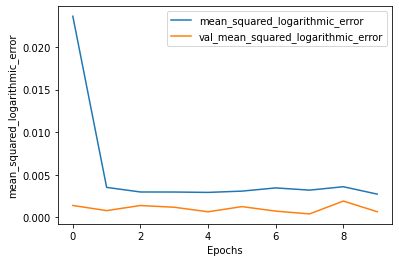

In [18]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [39]:
results = model.evaluate(test_scaler, y_test, batch_size=128)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 4ms/step - loss: 4.8839e-04 - mean_squared_logarithmic_error: 4.8113e-04
test loss, test acc: [0.0004883919027633965, 0.0004811309918295592]


In [40]:
result = model.predict(test_scaler)
result = pd.DataFrame(result,columns=['age_pred'])
result['age'] = y_test.to_numpy()
result['age_pred'] = result['age_pred'].round(1)
result.head()

27/27 [==============================] - 0s 2ms/step


,age_pred,age
0,15.4,15.5
1,11.3,11.5
2,11.4,11.5
3,12.3,12.5
4,12.6,12.5


###**Gradient Boosting Regressor Model**

In [34]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [20]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [22]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(train_scaler, y_train)

mse = mean_squared_error(y_test, reg.predict(test_scaler))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0019


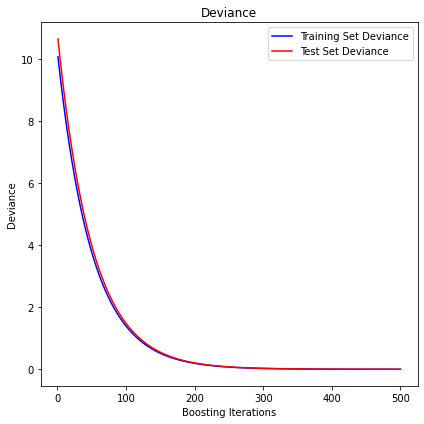

In [38]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
c=0
for i, y_pred in enumerate(reg.staged_predict(test_scaler)):
    test_score[i] = reg.loss_(y_test, y_pred)
    

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [37]:
result_mod2 = reg.predict(test_scaler)
result_mod2 = pd.DataFrame(result_mod2,columns=['age_pred'])
result_mod2['age'] = y_test.to_numpy()
result_mod2['age_pred'] = result_mod2['age_pred'].round(1)
result_mod2.head()

,age_pred,age
0,15.5,15.5
1,11.5,11.5
2,11.5,11.5
3,12.5,12.5
4,12.5,12.5
